In [1]:
# downloaded from https://grouplens.org/datasets/movielens/25m/

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import time
from tqdm import tqdm
dbg = True
# from google.colab import drive
# drive.mount('/content/gdrive')
nrows = {True:100000, False:None}[dbg]
rating_df = pd.read_csv('ml-25m/ratings.csv', nrows=nrows)
tag_df = pd.read_csv('ml-25m/tags.csv', nrows=nrows)
movie_df = pd.read_csv('ml-25m/movies.csv')
rating_df['userId'] = rating_df['userId'] - 1
rating_df['movieId'] = rating_df['movieId'] - 1
tag_df['userId'] = tag_df['userId'] - 1
tag_df['movieId'] = tag_df['movieId'] - 1
movie_df['movieId'] = movie_df['movieId'] - 1

rating_df['movieId'] = rating_df['movieId'].map({v: i for i, v in enumerate(rating_df['movieId'].unique())})
mismatch = set(rating_df["movieId"]).difference(movie_df["movieId"])
rating_df = rating_df.loc[~rating_df['movieId'].isin(mismatch)]

movie_counts = rating_df['movieId'].value_counts()
popular_movies = movie_counts[(movie_counts > 30)].index
rating_df = rating_df.loc[rating_df['movieId'].isin(popular_movies)]
user_counts = rating_df['userId'].value_counts()
popular_users = user_counts[(user_counts > 30)].index
rating_df = rating_df.loc[rating_df['userId'].isin(popular_users)]

movie_df = movie_df.loc[movie_df['movieId'].isin(rating_df['movieId'].unique())]
movie_id_map = {v:k for k, v in enumerate(rating_df['movieId'].unique())}
movie_df['movieId'] = movie_df['movieId'].map(movie_id_map).astype(int)
rating_df['movieId'] = rating_df['movieId'].map(movie_id_map).astype(int)
user_id_map = {v:k for k, v in enumerate(rating_df['userId'].unique())}
rating_df['userId'] = rating_df['userId'].map(user_id_map).astype(int)
rating_df = rating_df.reset_index(drop=True)
movie_df = movie_df.reset_index(drop=True)
mismatch = set(movie_df["movieId"]).difference(rating_df["movieId"])
movie_df = movie_df.drop(mismatch)
num_users = rating_df['userId'].nunique()
num_movies = rating_df['movieId'].nunique()

In [4]:
train_rows=np.random.choice(rating_df.shape[0], int(0.8*rating_df.shape[0]), replace=False)
ratings_train = rating_df.loc[train_rows]
test_rows = set(range(rating_df.shape[0])).difference(set(train_rows))
ratings_test = rating_df.loc[test_rows]

In [5]:
minrating, maxrating = rating_df['rating'].describe().loc[['min', 'max']]

In [6]:
tfph = tf.compat.v1.placeholder
tfvar = tf.compat.v1.get_variable
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
emb_size = 32

user_vec = tfvar('uservec', shape = (num_users, emb_size), dtype = tf.float32)
movie_vec = tfvar('movievec', shape = (num_movies, emb_size), dtype = tf.float32)
user_bias_vec = tfvar('userbiasvec', shape = (num_users), dtype = tf.float32)
movie_bias_vec = tfvar('moviebiasvec', shape = (num_movies), dtype = tf.float32)

user_ph = tfph(tf.int32, shape = (None))
movie_ph = tfph(tf.int32, shape = (None))
rating_ph = tfph(tf.float32, shape = (None))

# batch size, emb_size
user_emb = tf.gather(user_vec, user_ph)
movie_emb = tf.gather(movie_vec, movie_ph)

# batch size
user_bias_emb = tf.gather(user_bias_vec, user_ph)
movie_bias_emb = tf.gather(movie_bias_vec, movie_ph)

score_raw = tf.reduce_sum(user_emb * movie_emb, axis=1) + user_bias_emb + movie_bias_emb
score = score_raw * (maxrating - minrating) + minrating

reg = tf.reduce_mean(tf.square(user_emb)) + tf.reduce_mean(tf.square(movie_emb))
# reg = sum([tf.reduce_mean(tf.square(var)) for var in tf.v1.trainable_variables()])

mse = tf.reduce_mean(tf.square(score - rating_ph)) + reg * 1
loss = mse
opt_fcn = tf.compat.v1.train.AdamOptimizer()
opt = opt_fcn.minimize(mse)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()

In [7]:
epochs = 200
losses = []
chk_freq = 10
val_losses = []
early_stopping = False
batch_size = 64
minibatch = 1
n_trn = ratings_train.shape[0]
for ep in range(epochs):
    if minibatch:
        data_order = np.arange(n_trn)
        np.random.shuffle(data_order)
        num_batches = n_trn // batch_size
        loss_avg = 0
        for batch_idx in range(num_batches):
            if batch_idx != num_batches - 1:
                rows = data_order[batch_idx*batch_size: (batch_idx+1) * batch_size]
            else:
                rows = data_order[batch_idx*batch_size:]
            samples = ratings_train.iloc[rows]
            
            current_loss, _ = sess.run([loss, opt], {movie_ph: samples['movieId'], 
                                             user_ph: samples['userId'], 
                                             rating_ph: samples['rating']})
            loss_avg += current_loss * len(rows) / n_trn
        losses.append(loss_avg)
        
    else:
        current_loss, _ = sess.run([loss, opt], {movie_ph: ratings_train['movieId'], 
                                             user_ph: ratings_train['userId'], 
                                             rating_ph: ratings_train['rating']})
        losses.append(current_loss)
    
    if early_stopping:
        if ep % chk_freq == 0:
            last_chkpnt = f'rec_tst_{ep}'
            saver.save(sess, last_chkpnt)
    
    val_loss = sess.run(loss, {
        movie_ph: ratings_test['movieId'], 
        user_ph: ratings_test['userId'], 
        rating_ph: ratings_test['rating']})
    
    val_losses.append(val_loss)
    if early_stopping:
        if all([los > val_losses[ep - (ep % 10)] for los in val_losses[-3:]]):
            saver.restore(sess, last_chkpnt)
            restored_loss = sess.run(loss, {
                        movie_ph: ratings_test['movieId'], 
                        user_ph: ratings_test['userId'], 
                        rating_ph: ratings_test['rating']})
            val_losses.append(restored_loss)
            break

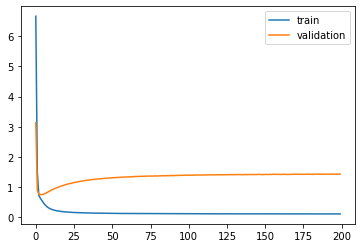

In [8]:
plt.plot(losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend()

In [9]:
sess.run(user_emb, {movie_ph: ratings_train['movieId'], 
                                             user_ph: ratings_train['userId'], 
                                             rating_ph: ratings_train['rating']})

array([[-0.19423315,  0.00947306, -0.04156949, ...,  0.07508617,
        -0.27963474, -0.20474143],
       [-0.11021894,  0.07126997,  0.03871029, ..., -0.05302844,
        -0.07525021, -0.31304505],
       [-0.07445328,  0.02183058, -0.22764665, ..., -0.15941912,
        -0.08695441,  0.2523462 ],
       ...,
       [ 0.09621845,  0.12246452, -0.03647408, ...,  0.0858254 ,
        -0.17149556, -0.00684653],
       [ 0.21738571,  0.03206794, -0.1468448 , ...,  0.46243075,
        -0.07667881, -0.0302492 ],
       [-0.05902959, -0.20798934, -0.19813858, ...,  0.40105018,
         0.02772743, -0.20837209]], dtype=float32)